In [1]:
import os
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import math, time
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import shap

e:\anaconda\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('../..')

In [3]:
import shap

In [4]:
dataset = pd.read_csv('data/data_nominal_clean.csv', sep=';',  index_col='date',  parse_dates=['date'])

In [5]:
pd.DataFrame(dataset['Gold'])

,Gold
date,
1986-01-02,326.30
1986-01-03,326.75
1986-01-06,328.00
1986-01-07,330.00
1986-01-08,332.60
...,...
2022-12-30,1813.75
2023-01-03,1843.25
2023-01-04,1857.30


lagging gold col

In [6]:
dataset['GoldLag']  = dataset['Gold'].shift(20)

In [7]:
df = dataset[['Gold', 'GoldLag']]
df

,Gold,GoldLag
date,,
1986-01-02,326.30,NaN
1986-01-03,326.75,NaN
1986-01-06,328.00,NaN
1986-01-07,330.00,NaN
1986-01-08,332.60,NaN
...,...,...
2022-12-30,1813.75,1753.50
2023-01-03,1843.25,1803.15
2023-01-04,1857.30,1784.75


In [8]:
df.dropna(inplace=True)
df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Gold,GoldLag
date,,
1986-01-30,358.00,326.30
1986-01-31,350.50,326.75
1986-02-03,347.30,328.00
1986-02-04,338.60,330.00
1986-02-05,337.30,332.60
...,...,...
2022-12-30,1813.75,1753.50
2023-01-03,1843.25,1803.15
2023-01-04,1857.30,1784.75


---
# LSTM univariate

In [9]:
X_train, y_train = df['GoldLag'].iloc[:-20].values, df['Gold'].iloc[:-20].values
X_test, y_test = df['GoldLag'].iloc[-20:].values, df['Gold'].iloc[-20:].values

In [10]:
scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_trains = scx.fit_transform(X_train.reshape(-1,1))
y_trains = scy.fit_transform(y_train.reshape(-1,1))

In [11]:
adam = Adam(lr=0.001)

The `lr` argument is deprecated, use `learning_rate` instead.


In [12]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_trains.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))

model.compile(loss='mse', optimizer=adam)

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            60400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 200)               240800    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)   

In [13]:
history = model.fit(X_trains, y_trains, batch_size=512, epochs=100, verbose=2, use_multiprocessing=True)

Epoch 1/100
18/18 - 9s - loss: 0.1372 - 9s/epoch - 473ms/step
Epoch 2/100
18/18 - 0s - loss: 0.0741 - 350ms/epoch - 19ms/step
Epoch 3/100
18/18 - 0s - loss: 0.0511 - 302ms/epoch - 17ms/step
Epoch 4/100
18/18 - 0s - loss: 0.0175 - 299ms/epoch - 17ms/step
Epoch 5/100
18/18 - 0s - loss: 0.0044 - 298ms/epoch - 17ms/step
Epoch 6/100
18/18 - 0s - loss: 0.0037 - 288ms/epoch - 16ms/step
Epoch 7/100
18/18 - 0s - loss: 0.0035 - 304ms/epoch - 17ms/step
Epoch 8/100
18/18 - 0s - loss: 0.0032 - 336ms/epoch - 19ms/step
Epoch 9/100
18/18 - 0s - loss: 0.0032 - 320ms/epoch - 18ms/step
Epoch 10/100
18/18 - 0s - loss: 0.0031 - 321ms/epoch - 18ms/step
Epoch 11/100
18/18 - 0s - loss: 0.0030 - 349ms/epoch - 19ms/step
Epoch 12/100
18/18 - 0s - loss: 0.0028 - 354ms/epoch - 20ms/step
Epoch 13/100
18/18 - 0s - loss: 0.0029 - 326ms/epoch - 18ms/step
Epoch 14/100
18/18 - 0s - loss: 0.0028 - 374ms/epoch - 21ms/step
Epoch 15/100
18/18 - 0s - loss: 0.0027 - 290ms/epoch - 16ms/step
Epoch 16/100
18/18 - 0s - loss: 0.00

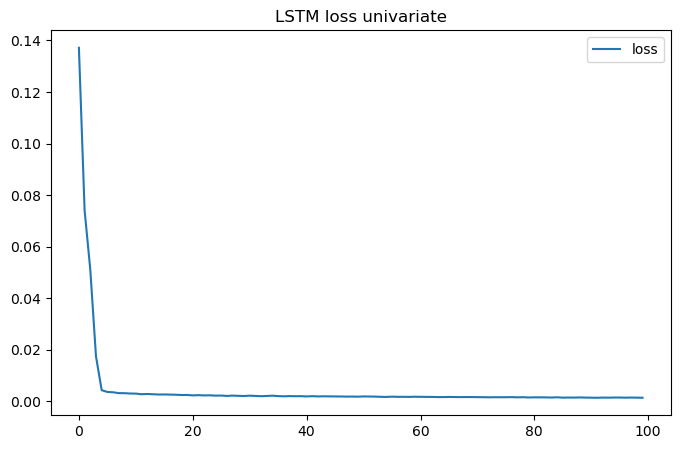

In [14]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title('LSTM loss univariate')
plt.show()

In [15]:
sctsx = MinMaxScaler(feature_range=(0,1))
sctsx.fit(X_test.reshape(-1,1))
X_tests = sctsx.transform(X_test.reshape(-1,1))

In [16]:
# preds1 = model.predict(X_tests[:5])
# preds2 = model.predict(preds1)
# preds3 = model.predict(preds2)
# preds4 = model.predict(preds3)

# fhats = np.concatenate((preds1, preds2, preds3, preds4))

In [17]:
# pred1 = model.predict(X_tests[0].reshape(-1,1))
# fhats = pred1
# for i in range(19):
#     val = model.predict(fhats[-1].reshape(-1,1))
#     fhats = np.append(fhats, val)

In [18]:
sctsy = MinMaxScaler(feature_range=(0,1))
sctsy.fit(y_test.reshape(-1,1))

MinMaxScaler()

In [19]:
fhats = model.predict(X_tests)

1/1 [==============================] - 1s 1s/step


In [20]:
hat_inv = sctsy.inverse_transform(fhats)

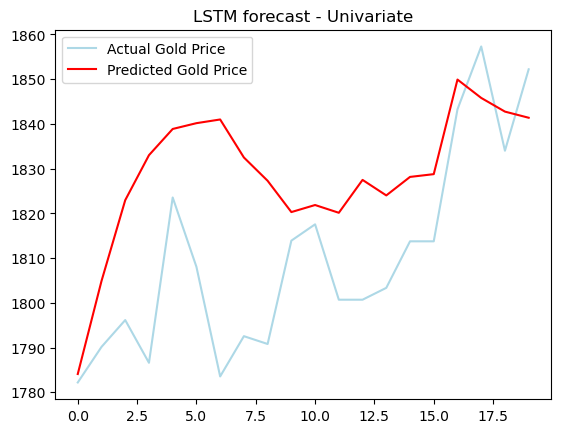

<Figure size 640x480 with 0 Axes>

In [21]:
plt.plot(y_test, color='lightblue', label='Actual Gold Price')
plt.plot(hat_inv, color='red',label='Predicted Gold Price')
plt.title('LSTM forecast - Univariate')
plt.legend()
plt.show()
plt.clf()

In [22]:
# metrics
mae_uv = mean_absolute_error(y_test, hat_inv)
mape_uv = mean_absolute_percentage_error(y_test, hat_inv)
mse_uv = mean_squared_error(y_test, hat_inv)
rmse_uv = np.sqrt(mse_uv)

In [23]:
print(f'MAE: {mae_uv}\nMAPE: {mape_uv}\nMSE: {mse_uv}\nRMSE: {rmse_uv}')

MAE: 20.789882812500004
MAPE: 0.0115415934925757
MSE: 648.2735422278649
RMSE: 25.461216432603234


In [24]:
res_dict = {'model':[], 'type':[], 'MAE':[], 'MAPE':[], 'MSE':[], 'RMSE':[]}

res_dict['model'].append('LSTM')
res_dict['type'].append('univariate')
res_dict['MAE'].append(mae_uv)
res_dict['MAPE'].append(mape_uv)
res_dict['MSE'].append(mse_uv)
res_dict['RMSE'].append(rmse_uv)

---
# LSTM multivariate

In [25]:
dataset[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']]  = dataset[['CrudeOil', 'S&P500', 'FTSE250']].shift(20)
dataset

,Gold,CrudeOil,S&P500,FTSE250,GoldLag,CrudeOilLag,S&P500Lag,FTSE250Lag
date,,,,,,,,
1986-01-02,326.30,25.56,209.59,1417.26,NaN,NaN,NaN,NaN
1986-01-03,326.75,26.00,210.88,1424.61,NaN,NaN,NaN,NaN
1986-01-06,328.00,26.53,210.65,1430.96,NaN,NaN,NaN,NaN
1986-01-07,330.00,25.85,213.80,1421.22,NaN,NaN,NaN,NaN
1986-01-08,332.60,25.87,207.97,1408.79,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-12-30,1813.75,80.16,3839.50,18853.00,1753.50,80.48,4080.11,19163.33
2023-01-03,1843.25,76.87,3824.14,19134.34,1803.15,81.06,4076.57,19409.42
2023-01-04,1857.30,72.82,3852.97,19391.07,1784.75,79.86,4071.70,19363.28


In [26]:
df = dataset[['Gold', 'CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].copy()

In [27]:
df.dropna(inplace=True)
df

,Gold,CrudeOilLag,S&P500Lag,FTSE250Lag
date,,,,
1986-01-30,358.00,25.56,209.59,1417.26
1986-01-31,350.50,26.00,210.88,1424.61
1986-02-03,347.30,26.53,210.65,1430.96
1986-02-04,338.60,25.85,213.80,1421.22
1986-02-05,337.30,25.87,207.97,1408.79
...,...,...,...,...
2022-12-30,1813.75,80.48,4080.11,19163.33
2023-01-03,1843.25,81.06,4076.57,19409.42
2023-01-04,1857.30,79.86,4071.70,19363.28


In [28]:
X_train, y_train = df[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].iloc[:-20].values, df['Gold'].iloc[:-20].values
X_test, y_test = df[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].iloc[-20:].values, df['Gold'].iloc[-20:].values

In [29]:
scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_trains = scx.fit_transform(X_train)
y_trains = scy.fit_transform(y_train.reshape(-1,1))

In [30]:
X_train

array([[   25.56,   209.59,  1417.26],
       [   26.  ,   210.88,  1424.61],
       [   26.53,   210.65,  1430.96],
       ...,
       [   88.14,  3719.89, 18109.61],
       [   92.58,  3770.55, 18341.57],
       [   91.8 ,  3806.8 , 18559.57]])

In [31]:
adam = Adam(lr=0.001)

The `lr` argument is deprecated, use `learning_rate` instead.


In [32]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_trains.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))

model.compile(loss='mse', optimizer=adam)

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 3, 50)             10400     
                                                                 
 dropout_3 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 100)            60400     
                                                                 
 dropout_4 (Dropout)         (None, 3, 100)            0         
                                                                 
 lstm_5 (LSTM)               (None, 200)               240800    
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1) 

In [33]:
history = model.fit(X_trains, y_trains, batch_size=512, epochs=100, verbose=2, use_multiprocessing=True)

Epoch 1/100
18/18 - 8s - loss: 0.1066 - 8s/epoch - 436ms/step
Epoch 2/100
18/18 - 1s - loss: 0.0501 - 732ms/epoch - 41ms/step
Epoch 3/100
18/18 - 1s - loss: 0.0228 - 732ms/epoch - 41ms/step
Epoch 4/100
18/18 - 1s - loss: 0.0207 - 703ms/epoch - 39ms/step
Epoch 5/100
18/18 - 1s - loss: 0.0191 - 705ms/epoch - 39ms/step
Epoch 6/100
18/18 - 1s - loss: 0.0185 - 707ms/epoch - 39ms/step
Epoch 7/100
18/18 - 1s - loss: 0.0176 - 752ms/epoch - 42ms/step
Epoch 8/100
18/18 - 1s - loss: 0.0169 - 710ms/epoch - 39ms/step
Epoch 9/100
18/18 - 1s - loss: 0.0164 - 710ms/epoch - 39ms/step
Epoch 10/100
18/18 - 1s - loss: 0.0155 - 790ms/epoch - 44ms/step
Epoch 11/100
18/18 - 1s - loss: 0.0151 - 712ms/epoch - 40ms/step
Epoch 12/100
18/18 - 1s - loss: 0.0145 - 709ms/epoch - 39ms/step
Epoch 13/100
18/18 - 1s - loss: 0.0138 - 695ms/epoch - 39ms/step
Epoch 14/100
18/18 - 1s - loss: 0.0133 - 723ms/epoch - 40ms/step
Epoch 15/100
18/18 - 1s - loss: 0.0131 - 894ms/epoch - 50ms/step
Epoch 16/100
18/18 - 1s - loss: 0.01

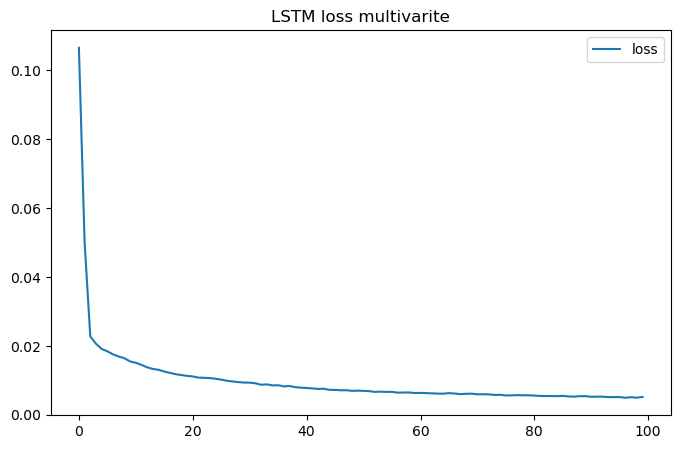

In [34]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title('LSTM loss multivarite')
plt.show()

In [35]:
sctsx = MinMaxScaler(feature_range=(0,1))
sctsx.fit(X_test)
X_tests = sctsx.transform(X_test)

In [36]:
sctsy = MinMaxScaler(feature_range=(0,1))
sctsy.fit(y_test.reshape(-1,1))
#ytt = sctsy.transform(y_test.reshape(-1,1))

MinMaxScaler()

In [37]:
fhats = model.predict(X_tests)

1/1 [==============================] - 1s 1s/step


In [38]:
hat_inv = sctsy.inverse_transform(fhats)

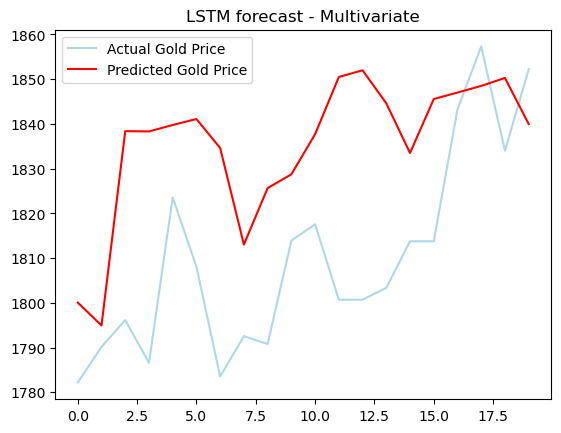

<Figure size 640x480 with 0 Axes>

In [39]:
plt.plot(y_test, color='lightblue', label='Actual Gold Price')
plt.plot(hat_inv, color='red',label='Predicted Gold Price')
plt.title('LSTM forecast - Multivariate')
plt.legend()
plt.show()
plt.clf()

In [40]:
# metrics
mae_mv = mean_absolute_error(y_test, hat_inv)
mape_mv = mean_absolute_percentage_error(y_test, hat_inv)
mse_mv = mean_squared_error(y_test, hat_inv)
rmse_mv = np.sqrt(mse_mv)

In [41]:
print(f'MAE: {mae_mv}\nMAPE: {mape_mv}\nMSE: {mse_mv}\nRMSE: {rmse_mv}')

MAE: 27.10422607421875
MAPE: 0.015036811100733993
MSE: 986.6890121249562
RMSE: 31.411606328313685


In [42]:
res_dict['model'].append('LSTM')
res_dict['type'].append('multivariate')
res_dict['MAE'].append(mae_mv)
res_dict['MAPE'].append(mape_mv)
res_dict['MSE'].append(mse_mv)
res_dict['RMSE'].append(rmse_mv)

In [43]:
pd.DataFrame(res_dict)

,model,type,MAE,MAPE,MSE,RMSE
0,LSTM,univariate,20.789883,0.011542,648.273542,25.461216
1,LSTM,multivariate,27.104226,0.015037,986.689012,31.411606


---

In [44]:
shap.initjs()

In [45]:
explainermv = shap.DeepExplainer(model, X_train)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


In [46]:
shap_values_mv = explainermv.shap_values(X_test)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    File "e:\anaconda\envs\thesis\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 247, in grad_graph  *
        out = self.model(shap_rAnD)
    File "e:\anaconda\envs\thesis\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "e:\anaconda\envs\thesis\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 378, in custom_grad
        out = op_handlers[type_name](self, op, *grads) # we cut off the shap_ prefex before the lookup
    File "e:\anaconda\envs\thesis\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 667, in handler
        return linearity_with_excluded_handler(input_inds, explainer, op, *grads)
    File "e:\anaconda\envs\thesis\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 674, in linearity_with_excluded_handler
        assert not explainer._variable_inputs(op)[i], str(i) + "th input to " + op.name + " cannot vary!"
    File "e:\anaconda\envs\thesis\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 224, in _variable_inputs
        out[i] = t.name in self.between_tensors

    AttributeError: Exception encountered when calling layer "lstm_4" "                 f"(type LSTM).
    
    'TFDeep' object has no attribute 'between_tensors'
    
    Call arguments received by layer "lstm_4" "                 f"(type LSTM):
      • inputs=tf.Tensor(shape=(18218, 3, 50), dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [ ]:
import tensorflow
tensorflow.__version__

'2.8.2'